## **Pretraiend Model**

In [1]:
import numpy as np
import pandas as pd
import os
import warnings
warnings.filterwarnings(action='ignore')
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam , RMSprop 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint , LearningRateScheduler
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import Xception

In [2]:
from tensorflow.keras.datasets import cifar10

(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
print("train dataset shape:", train_images.shape, train_labels.shape)
print("test dataset shape:", test_images.shape, test_labels.shape)

170508288/170498071 [==============================] - 6s 0us/step
train dataset shape: (50000, 32, 32, 3) (50000, 1)
test dataset shape: (10000, 32, 32, 3) (10000, 1)


In [3]:
IMAGE_SIZE = 32
BATCH_SIZE = 64
def preprocessed_data(images, labels):
    # 이미지 scale 및 float32 형 변형
    images = np.array(images, dtype=np.float32)
    labels = np.array(labels, dtype=np.float32)
    return images, labels

def ohe_data(images, labels):
    # 라벨 원핫인코딩 적용
    images, labels = preprocessed_data(images, labels)
    oh_labels = to_categorical(labels)
    return images, oh_labels

def train_valid_split(train_images, train_labels, test_images, test_labels, valid_size, random_state):
    train_images, train_oh_labels = ohe_data(train_images, train_labels)
    test_images, test_oh_labels = ohe_data(test_images, test_labels)
    train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_oh_labels, test_size=valid_size, random_state=random_state)
    return (train_images, train_labels), (val_images, val_labels), (test_images, test_oh_labels)

def create_model():
    # VGG16
    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    base_model = VGG16(input_tensor=input_tensor, include_top=False, weights='imagenet')
    base_output = base_model.output
    x = GlobalAveragePooling2D()(base_output)
    x = Dense(50, activation='relu', name='GAP1')(x)
    output = Dense(train_labels.shape[1], activation='softmax', name='output')(x)
    
    model = Model(inputs=input_tensor, outputs=output)
    model.summary()
    return model

In [4]:
(train_images, train_labels), (val_images, val_labels), (test_images, test_labels) = train_valid_split(train_images, train_labels, test_images, test_labels, 0.15, 2021)
print(train_images.shape, train_labels.shape, val_images.shape, val_labels.shape, test_images.shape, test_labels.shape)

(42500, 32, 32, 3) (42500, 10) (7500, 32, 32, 3) (7500, 10) (10000, 32, 32, 3) (10000, 10)


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(
    horizontal_flip=True,
    rescale=1/255.0,
    #vertical_flip,
    #rotation_range,
)
valid_generator = ImageDataGenerator(rescale=1/255.0)

flow_train_gen = train_generator.flow(train_images, train_labels, batch_size = 64)
flow_valid_gen = valid_generator.flow(val_images, val_labels, batch_size = 64, shuffle=False)

In [6]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping

model = create_model()
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, mode='min', verbose=1)
ely_cb = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

history = model.fit(flow_train_gen, epochs=30, validation_data=flow_valid_gen, callbacks=[rlr_cb, ely_cb])

2022-04-11 13:10:32.844475: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-11 13:10:32.955190: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-11 13:10:32.956371: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-11 13:10:32.958158: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

58900480/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
______________________________________________________________

2022-04-11 13:10:37.433213: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2022-04-11 13:10:40.179047: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


665/665 [==============================] - 28s 29ms/step - loss: 1.9429 - accuracy: 0.2295 - val_loss: 1.8190 - val_accuracy: 0.3152
Epoch 2/30
665/665 [==============================] - 18s 28ms/step - loss: 1.3996 - accuracy: 0.4644 - val_loss: 1.1354 - val_accuracy: 0.5748
Epoch 3/30
665/665 [==============================] - 18s 27ms/step - loss: 1.0509 - accuracy: 0.6244 - val_loss: 0.9330 - val_accuracy: 0.6759
Epoch 4/30
665/665 [==============================] - 18s 28ms/step - loss: 0.8604 - accuracy: 0.7045 - val_loss: 0.8675 - val_accuracy: 0.7169
Epoch 5/30
665/665 [==============================] - 19s 28ms/step - loss: 0.7495 - accuracy: 0.7446 - val_loss: 0.7711 - val_accuracy: 0.7436
Epoch 6/30
665/665 [==============================] - 18s 27ms/step - loss: 0.6571 - accuracy: 0.7819 - val_loss: 0.7651 - val_accuracy: 0.7504
Epoch 7/30
665/665 [==============================] - 18s 28ms/step - loss: 0.6009 - accuracy: 0.8009 - val_loss: 0.6477 - val_accuracy: 0.7995
Epo

313/313 [==============================] - 3s 9ms/step - loss: 1.0940 - accuracy: 0.8495


[1.0940457582473755, 0.8495000004768372]

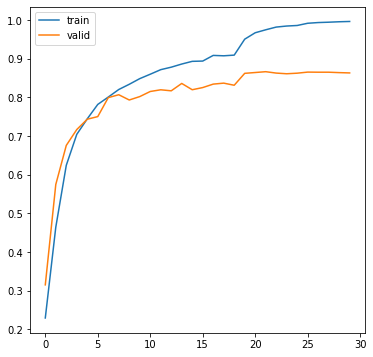

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_history(history):
    plt.figure(figsize=(6, 6))
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='valid')
    plt.legend()
    
show_history(history)

# 테스트 데이터로 성능 평가
test_generator = ImageDataGenerator(rescale=1/255.0)
flow_test_gen = test_generator.flow(test_images, test_labels, shuffle=False)
model.evaluate(flow_test_gen)

* VGG16 사용시 이미지사이즈가 작아 featuremap -> 1x1
* 이로인해 이전보다 성능이 안좋아지므로 이미지사이즈를 늘리는 시도 가능